

1.   Imports FASTA file
2.   Runs a CLUSTAL OMEGA alignment
3.   Prints a guide tree
4.   Asks at which branch point you want to split the file
5.   Makes new FASTA files containing the new clusters



In [1]:
# Install necessary packages
!pip install biopython
!apt-get install -y clustalo
import os
import subprocess
from Bio import Phylo, SeqIO
import matplotlib.pyplot as plt
from google.colab import files

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 8.6 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libargtable2-0
The following NEW packages will be installed:
  clustalo libargtable2-0
0 upgraded, 2 newly installed, 0 to remove and 45 not upgraded.
Need to get 273 kB of archives.
After this operation, 694 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libargtable2-0 amd64 13-1.1 [14.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 clustalo amd64 1.2.4-7 [259 kB]
Fetched 273 kB in 0s (939 kB/s)
Selecting previously unselected package libargtable2-0.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../libargtable2-0_13-1.1_amd64.deb ...
Unpacking libargtable2-0 (13-1.1) ...
Selecting previously unselected package clustalo.
Preparing to unpack 

In [5]:
# Step 1: Upload a multipart FASTA protein file
uploaded = files.upload()

Saving CA_patents_no_abody_abodies_255_out_full.FASTA to CA_patents_no_abody_abodies_255_out_full.FASTA


In [6]:
# Step 2: Run sequences through Clustal Omega for multiple sequence alignment
for file_name in uploaded.keys():
    fasta_file = file_name
    alignment_file = f"{os.path.splitext(fasta_file)[0]}.aln"
    subprocess.run(["clustalo", "-i", fasta_file, "-o", alignment_file])

    # Step 3: Build a Newick tree from the alignment
    tree_file = f"{os.path.splitext(fasta_file)[0]}.dnd"
    subprocess.run(["clustalo", "--guidetree-out", tree_file, "-i", alignment_file])

    # Read the Newick tree from the file
    with open(tree_file, 'r') as f:
        newick_tree = f.readline().strip()

    # Parse the Newick tree to obtain sequence identifiers
    def extract_sequence_identifiers(newick_tree):
        tree = Phylo.read(tree_file, "newick")
        return [leaf.name for leaf in tree.get_terminals()]

    sequence_identifiers = extract_sequence_identifiers(newick_tree)


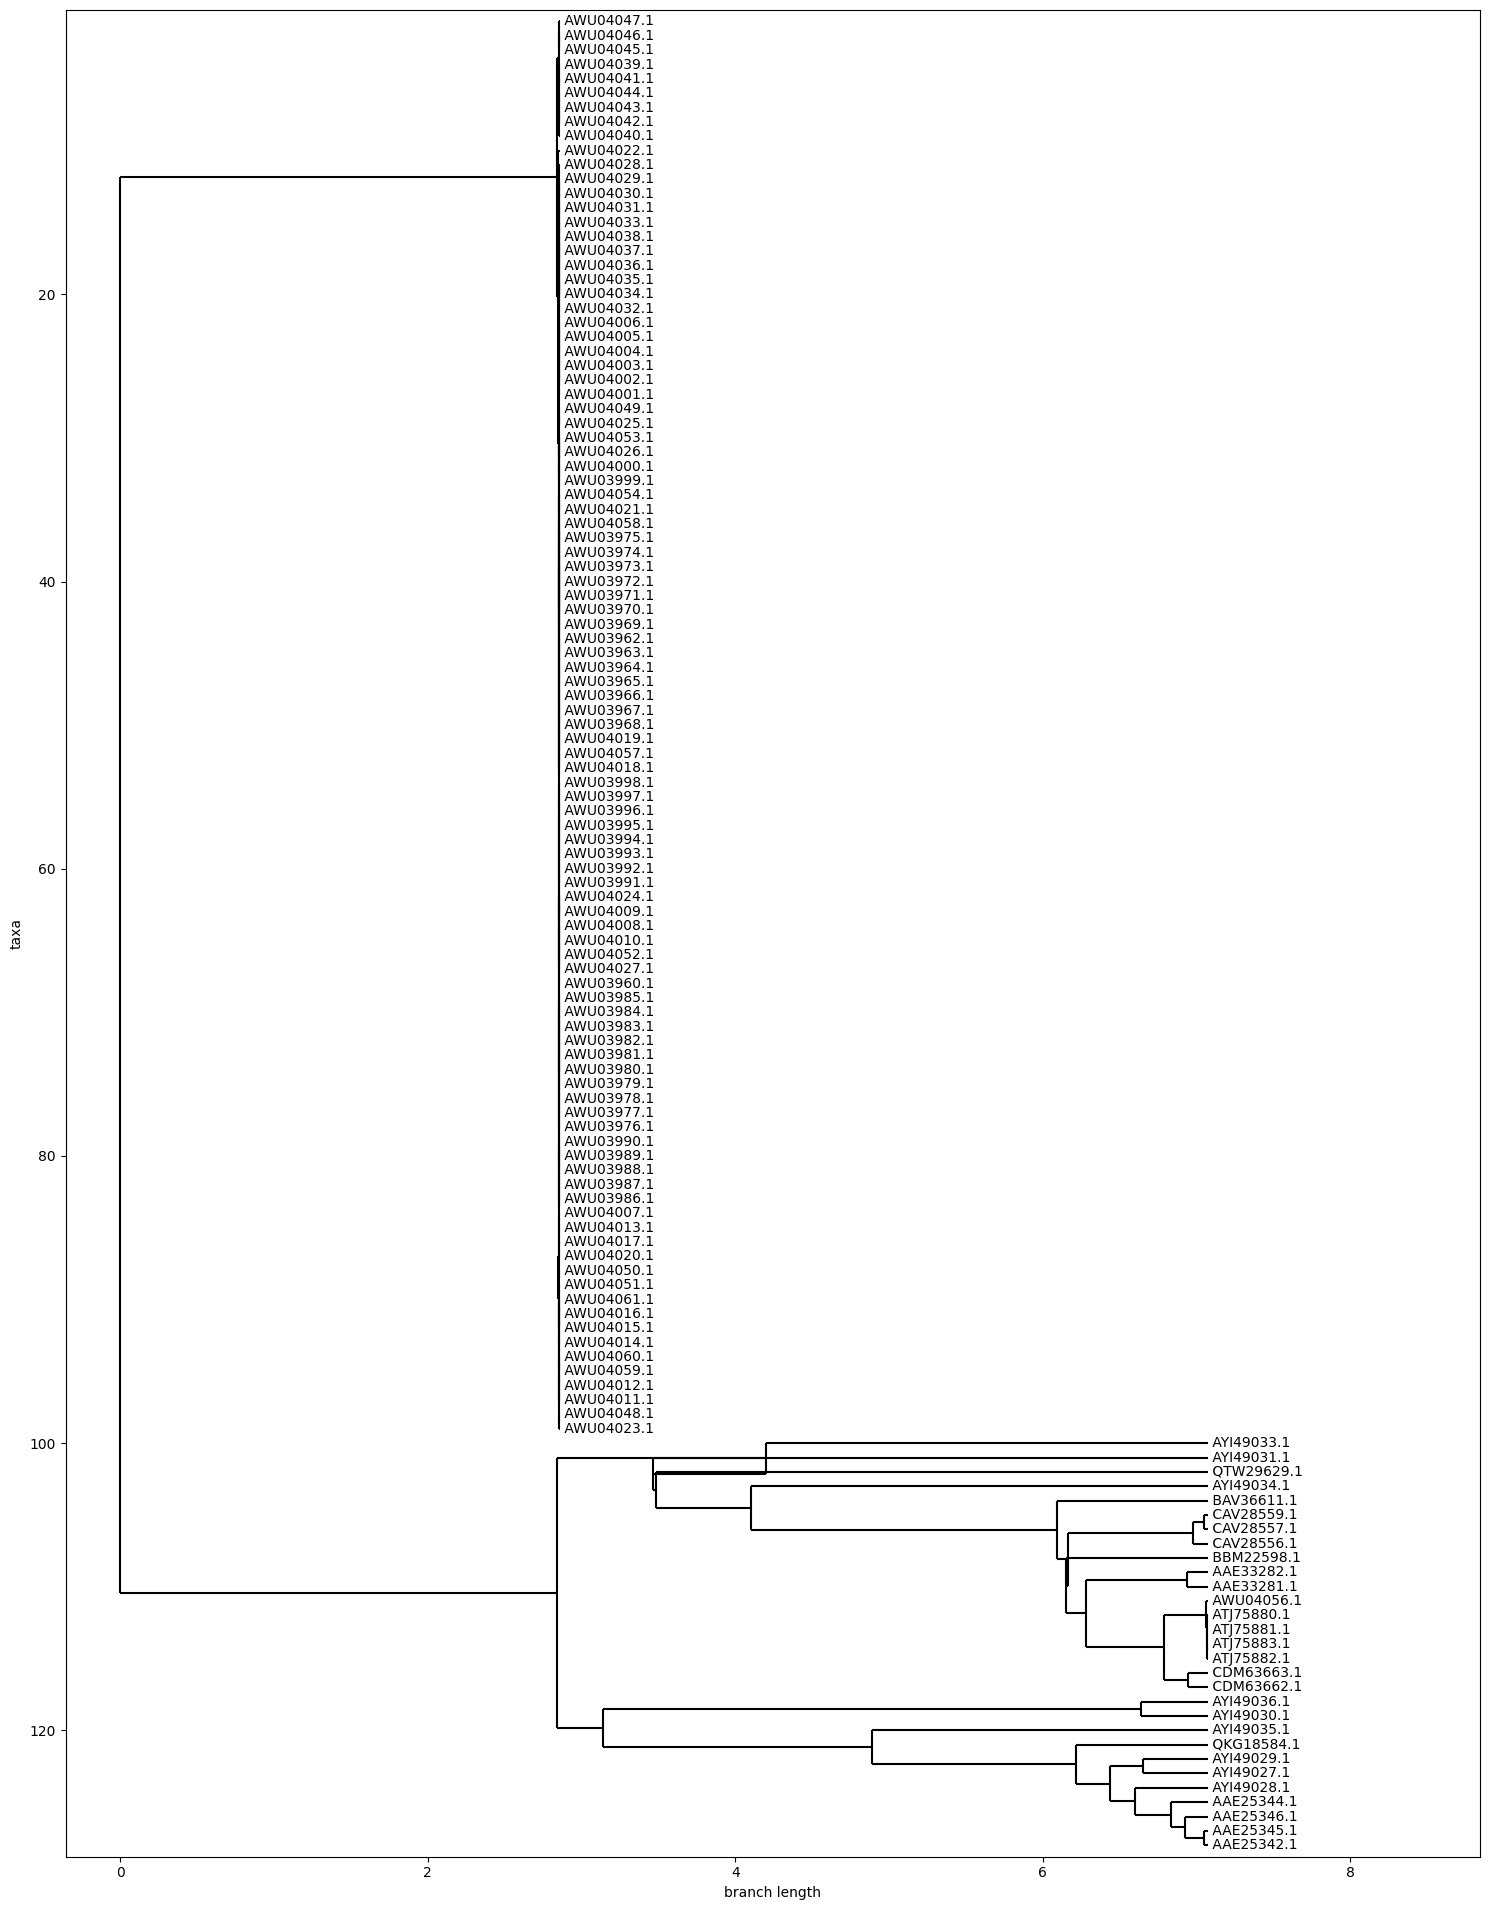

In [7]:
    # Step 4: Display the Newick tree
    tree = Phylo.read(tree_file, "newick")

    # Automate figure size based on the number of sequence identifiers
    num_sequences = len(sequence_identifiers)
    fig_width = 15
    fig_height = max(10, num_sequences * 0.15)  # Adjust the height dynamically

    # Create a figure with a dynamic size
    fig = plt.figure(figsize=(fig_width, fig_height))  # Adjust the figure size to ensure identifiers do not overlap
    ax = fig.add_subplot(1, 1, 1)

    # Draw the tree with specific parameters to avoid overlap
    Phylo.draw(tree, do_show=False, axes=ax)

    # Improve the layout to prevent overlapping
    plt.tight_layout()

    plt.show()

In [8]:
# Parse the Newick tree to obtain the first branch point
def extract_first_branch_point(newick_tree):
    tree = Phylo.read(tree_file, "newick")
    for node in tree.find_clades():
        if len(node.clades) == 2:  # Assuming binary tree
            return node

first_branch_point = extract_first_branch_point(newick_tree)

# Split the tree into clusters at the first branch point
def split_tree_into_clusters(tree, first_branch_point):
    clusters = {}
    for child in first_branch_point.clades:
        clusters[child.name] = {}
        for leaf in Phylo.BaseTree.Clade.get_terminals(child):
            clusters[child.name][leaf.name] = ""
    return clusters

clusters = split_tree_into_clusters(newick_tree, first_branch_point)

# Write sequences of each cluster into new FASTA files
def write_fasta_file(cluster, cluster_name):
    with open(f"{cluster_name}.fasta", 'w') as f:
        for seq_id in cluster.keys():
            f.write(f">{seq_id}\n")  # No sequence data, as it's not available in the Newick tree

# Write sequences into new FASTA files
for cluster_name, cluster in clusters.items():
    write_fasta_file(cluster, cluster_name)